<a href="https://colab.research.google.com/github/vignesh-0510/SolarFlareExplainableWindowDetection/blob/main/phase_2_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, jaccard_score
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import tqdm
import pickle

seed = 42
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
metadata_columns = ['index', 'class',	'filename',	'category',	'sub_category',	'start_time',	'end_time']
interacting_columns = ['TOTUSJH', 'TOTPOT', 'TOTUSJZ']
expanded_columns = []
for col in interacting_columns:
  for i in range(10):
    expanded_columns.append(f'{col}_real_{i}')
df_partition1 = pd.read_csv('/content/drive/MyDrive/ADM/partition1/swan_sf_partition1_interacting_features_normalized.csv')
df_partition2 = pd.read_csv('/content/drive/MyDrive/ADM/partition2/swan_sf_partition2_interacting_features_normalized.csv')
df_partition3 = pd.read_csv('/content/drive/MyDrive/ADM/partition3/swan_sf_partition3_interacting_features_normalized.csv')
df_partition4 = pd.read_csv('/content/drive/MyDrive/ADM/partition4/swan_sf_partition4_interacting_features_normalized.csv')


In [ ]:
print(f"Partition 1 FL shape: {df_partition1[df_partition1['class'] == 'FL'].shape}")
print(f"Partition 2 FL shape: {df_partition2[df_partition2['class'] == 'FL'].shape}")
print(f"Partition 3 FL shape: {df_partition3[df_partition3['class'] == 'FL'].shape}")
print(f"Partition 4 FL shape: {df_partition4[df_partition4['class'] == 'FL'].shape}")

Partition 1 FL shape: (1254, 36)
Partition 2 FL shape: (1401, 36)
Partition 3 FL shape: (1424, 36)
Partition 4 FL shape: (1165, 36)


In [ ]:
def evaluate_metrics(y_true, y_pred):
    pos_lbl = 0 if y_true.dtype in ['int64','int32'] else 'FL'
    metrics = {}
    metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
    metrics['geometric_mean'] = geometric_mean_score(y_true, y_pred)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro')
    metrics['f1_weighted'] = f1_score(y_true, y_pred, average='weighted')
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro')
    metrics['precision_weighted'] = precision_score(y_true, y_pred, average='weighted')
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro')
    metrics['recall_weighted'] = recall_score(y_true, y_pred, average='weighted')
    metrics['jaccard_macro'] = jaccard_score(y_true, y_pred, pos_label=pos_lbl)
    metrics['jaccard_weighted'] = jaccard_score(y_true, y_pred, average='weighted')
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)
    tp,fn,fp,tn = metrics['confusion_matrix'].ravel()
    tss = (tp / (tp + fn)) - (fp / (fp + tn))
    hss = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
    metrics['tss'] = tss
    metrics['hss'] = hss
    metrics['classification_report'] = classification_report(y_true, y_pred)
    return metrics

def print_metrics(metrics, title):
    print(title, 'Results')
    print('='*40)
    for k,v in metrics.items():
        if k in ('confusion_matrix', 'classification_report'):
            print(f'{k:<20}')
            print(v,'\n')
            continue
        print(f'{k:<20}: {v:.5f}')
metrics_dict = {}

In [ ]:
def fetch_samples(df_new):

  fl_records = df_new[df_new['class'] == 'FL']
  fl_count = len(fl_records)


  num_c = int((3/6) * fl_count)  # 50% from C
  num_b = int((2/6) * fl_count)  # 33.33% from B
  num_fq = fl_count - (num_c + num_b)  # Remaining from FQ

  # Sample without replacement and handle cases where available data is insufficient
  c_samples = df_new[(df_new['class'] == 'NF') & (df_new['category'] == 'C')].sample(
      n=min(num_c, len(df_new[(df_new['class'] == 'NF') & (df_new['category'] == 'C')])), random_state=42, replace=False)

  b_samples = df_new[(df_new['class'] == 'NF') & (df_new['category'] == 'B')].sample(
      n=min(num_b, len(df_new[(df_new['class'] == 'NF') & (df_new['category'] == 'B')])), random_state=42, replace=False)

  # If C & B samples are less than expected, adjust FQ sampling
  remaining_needed = fl_count - (len(c_samples) + len(b_samples))

  fq_samples = df_new[(df_new['class'] == 'NF') & (df_new['category'] == 'FQ')].sample(
      n=min(remaining_needed, len(df_new[(df_new['class'] == 'NF') & (df_new['category'] == 'FQ')])), random_state=42, replace=False)


  balanced_sample = pd.concat([fl_records, c_samples, b_samples, fq_samples])

  balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)
  return balanced_sample

In [ ]:
df_train = pd.concat([fetch_samples(df_partition1), fetch_samples(df_partition2), fetch_samples(df_partition3)], axis=0)
# df_test = fetch_samples(df_partition4)
df_test = df_partition4

print(f"Train data FL shape: {df_train[df_train['class'] == 'FL'].shape}")
print(f"Test data FL shape: {df_test[df_test['class'] == 'FL'].shape}")

Train data FL shape: (4079, 36)
Test data FL shape: (1165, 36)


In [ ]:
df_train

,class,filename,category,sub_category,start_time,end_time,TOTUSJH_real_0,TOTUSJH_real_1,TOTUSJH_real_2,TOTUSJH_real_3,...,TOTUSJZ_real_0,TOTUSJZ_real_1,TOTUSJZ_real_2,TOTUSJZ_real_3,TOTUSJZ_real_4,TOTUSJZ_real_5,TOTUSJZ_real_6,TOTUSJZ_real_7,TOTUSJZ_real_8,TOTUSJZ_real_9
0,NF,B2.6@1107:Primary_ar355_s2011-02-02T15:24:00_e...,B,2.6,2011-02-02T15:24:00,2011-02-03T03:12:00,3.233145,-0.045243,-0.048234,0.046950,...,2.028930,-0.048130,-0.019194,0.076237,-0.033124,-0.030937,0.060985,-0.025557,-0.024506,0.058947
1,FL,X1.5@1428:Primary_ar401_s2011-03-08T11:36:00_e...,X,1.5,2011-03-08T11:36:00,2011-03-08T23:24:00,29.625620,0.033434,0.065290,0.021184,...,19.443949,0.039584,-0.037293,0.083374,-0.038366,-0.000750,-0.001291,0.003068,0.010699,0.003608
2,NF,FQ_ar1168_s2011-12-15T10:48:00_e2011-12-15T22:...,FQ,NaN,2011-12-15T10:48:00,2011-12-15T22:36:00,4.453026,0.001415,-0.010551,0.018659,...,3.381708,0.034866,-0.050287,0.028928,-0.003788,0.002229,-0.004599,-0.003658,-0.005706,-0.002336
3,NF,C1.1@2299:Primary_ar794_s2011-08-21T16:24:00_e...,C,1.1,2011-08-21T16:24:00,2011-08-22T04:12:00,11.041815,0.101091,0.003047,0.171937,...,8.177865,0.028531,0.051130,0.132373,-0.133215,-0.020677,0.000000,-0.014584,-0.022393,-0.029523
4,NF,C1.0@1543:Primary_ar443_s2011-03-26T12:48:00_e...,C,1.0,2011-03-26T12:48:00,2011-03-27T00:36:00,2.623201,0.000000,0.005591,-0.032861,...,1.674903,-0.006034,-0.029064,0.024893,-0.012857,-0.007398,-0.005386,-0.007774,-0.006298,-0.005075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2843,NF,C1.1@6779:Secondary_ar3295_s2013-10-20T15:00:0...,C,1.1,2013-10-20T15:00:00,2013-10-21T02:48:00,12.417693,0.101595,0.163965,-0.058988,...,16.572425,0.201152,0.006528,-0.153494,-0.063186,-0.026556,-0.019768,-0.011729,-0.024439,-0.016398
2844,FL,M1.0@7391:Primary_ar3580_s2014-01-05T18:00:00_...,M,1.0,2014-01-05T18:00:00,2014-01-06T05:48:00,4.336414,-0.060339,0.017000,-0.007299,...,5.837615,-0.040935,0.069006,0.031112,-0.021325,-0.016857,-0.012687,-0.013013,-0.019845,0.000000
2845,FL,X1.2@7398:Primary_ar3563_s2014-01-06T13:00:00_...,X,1.2,2014-01-06T13:00:00,2014-01-07T00:48:00,38.121922,-0.373172,0.230667,0.039160,...,54.153065,-0.086958,-0.010877,0.107693,0.108071,0.048308,0.039551,0.059992,0.019654,0.065364
2846,FL,M3.5@7831:Primary_ar3813_s2014-03-10T11:24:00_...,M,3.5,2014-03-10T11:24:00,2014-03-10T23:12:00,11.008247,-0.096113,0.013830,-0.072842,...,14.327545,-0.038311,0.069291,-0.183718,0.070251,-0.022724,-0.014658,-0.019742,-0.003870,0.003066


# Decision Tree Classifier

In [ ]:
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=seed)

In [ ]:
dt_clf.fit(df_train[expanded_columns], df_train['class'])

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

In [ ]:
y_pred = dt_clf.predict(df_test[expanded_columns])
y_pred_proba = dt_clf.predict_proba(df_test[expanded_columns])
metrics = evaluate_metrics(df_test['class'], y_pred)
metrics_dict['decision_tree'] = metrics
print_metrics(metrics, title ='Decision Tree Classifier')

Decision Tree Classifier Results
balanced_accuracy   : 0.57105
geometric_mean      : 0.49571
f1_macro            : 0.49483
f1_weighted         : 0.89438
accuracy            : 0.84165
precision_macro     : 0.51247
precision_weighted  : 0.95968
recall_macro        : 0.57105
recall_weighted     : 0.84165
jaccard_macro       : 0.03964
jaccard_weighted    : 0.82241
confusion_matrix    
[[  335   830]
 [ 7287 42809]] 

tss                 : 0.14209
hss                 : 0.03833
classification_report
              precision    recall  f1-score   support

          FL       0.04      0.29      0.08      1165
          NF       0.98      0.85      0.91     50096

    accuracy                           0.84     51261
   macro avg       0.51      0.57      0.49     51261
weighted avg       0.96      0.84      0.89     51261
 



In [ ]:
dt_clf.feature_importances_

array([0.74903304, 0.01545664, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00665896, 0.03314218, 0.00805448,
       0.12109213, 0.        , 0.        , 0.        , 0.        ,
       0.01922183, 0.        , 0.00411101, 0.        , 0.        ,
       0.03074946, 0.        , 0.        , 0.00650467, 0.        ,
       0.00597562, 0.        , 0.        , 0.        , 0.        ])

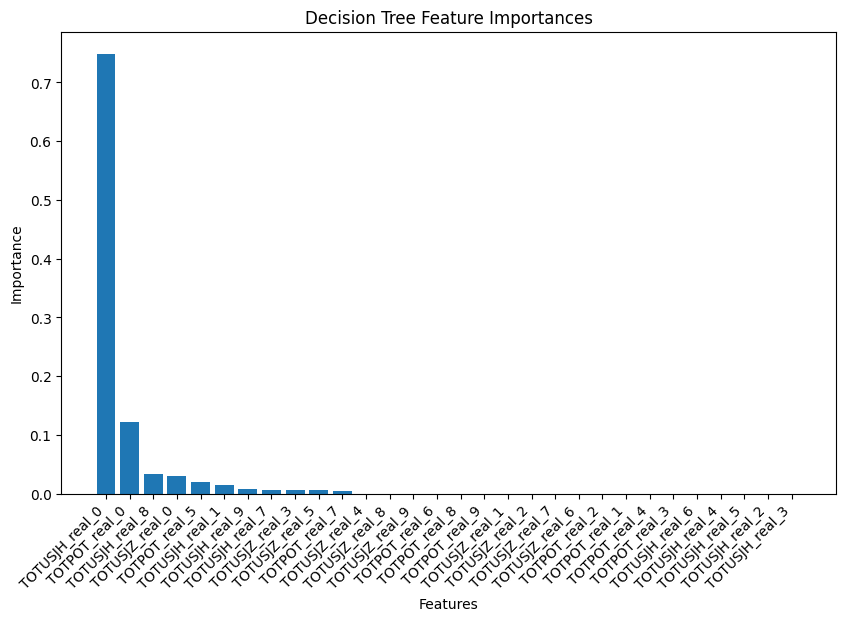

In [ ]:
dt_clf_feature_importances = dt_clf.feature_importances_
sorted_indices = np.argsort(dt_clf_feature_importances)[::-1]
sorted_feature_names = [expanded_columns[i] for i in sorted_indices]
sorted_importances = dt_clf_feature_importances[sorted_indices]
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=45, ha='right')
plt.title('Decision Tree Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
y_pred = dt_clf.predict(df_train[expanded_columns])
y_pred_proba = dt_clf.predict_proba(df_test[expanded_columns])
metrics = evaluate_metrics(df_train['class'], y_pred)
# metrics_dict['decision_tree'] = metrics
print_metrics(metrics, title ='Decision Tree Classifier Train Data')

Decision Tree Classifier Train Data Results
balanced_accuracy   : 0.78475
geometric_mean      : 0.77844
f1_macro            : 0.78261
f1_weighted         : 0.78261
accuracy            : 0.78475
precision_macro     : 0.79644
precision_weighted  : 0.79644
recall_macro        : 0.78475
recall_weighted     : 0.78475
jaccard_macro       : 0.67251
jaccard_weighted    : 0.64337
confusion_matrix    
[[3606  473]
 [1283 2796]] 

tss                 : 0.56950
hss                 : 0.56950
classification_report
              precision    recall  f1-score   support

          FL       0.74      0.88      0.80      4079
          NF       0.86      0.69      0.76      4079

    accuracy                           0.78      8158
   macro avg       0.80      0.78      0.78      8158
weighted avg       0.80      0.78      0.78      8158
 



In [ ]:
with open('/content/drive/MyDrive/ADM/results/part_123/dt_clf.pkl', 'wb') as f:
    pickle.dump(dt_clf, f)

In [ ]:
conf = np.array([t[0] for t in y_pred_proba if t[0] >= 0.5 ])
print(conf.shape)
print(conf[:100])

(7622,)
[0.60116732 0.60116732 0.60116732 0.60116732 0.60116732 0.60116732
 0.60116732 0.60116732 0.60116732 0.87704918 0.60116732 0.60116732
 0.60116732 0.68307485 0.60116732 0.60116732 0.60116732 0.60116732
 0.60116732 0.60116732 0.60116732 0.60116732 0.60116732 0.60116732
 0.60116732 0.60116732 0.68307485 0.60116732 0.87704918 0.60116732
 0.60116732 0.60116732 0.60116732 0.60116732 0.60116732 0.60116732
 0.60116732 0.60116732 0.60116732 0.60116732 0.87704918 0.60116732
 0.60116732 0.60116732 0.87704918 0.60116732 0.60116732 0.83704572
 0.60116732 0.60116732 0.87704918 0.60116732 0.60116732 0.60116732
 0.68307485 0.60116732 0.68307485 0.60116732 0.60116732 0.60116732
 0.60116732 0.60116732 0.60116732 0.60116732 0.60116732 0.60116732
 0.60116732 0.60116732 0.60116732 0.60116732 0.60116732 0.58823529
 0.60116732 0.60116732 0.60116732 0.60116732 0.83704572 0.83704572
 0.60116732 0.60116732 0.60116732 0.60116732 0.60116732 0.60116732
 0.60116732 0.87704918 0.60116732 0.60116732 0.6011673

In [ ]:
from sklearn.tree import plot_tree

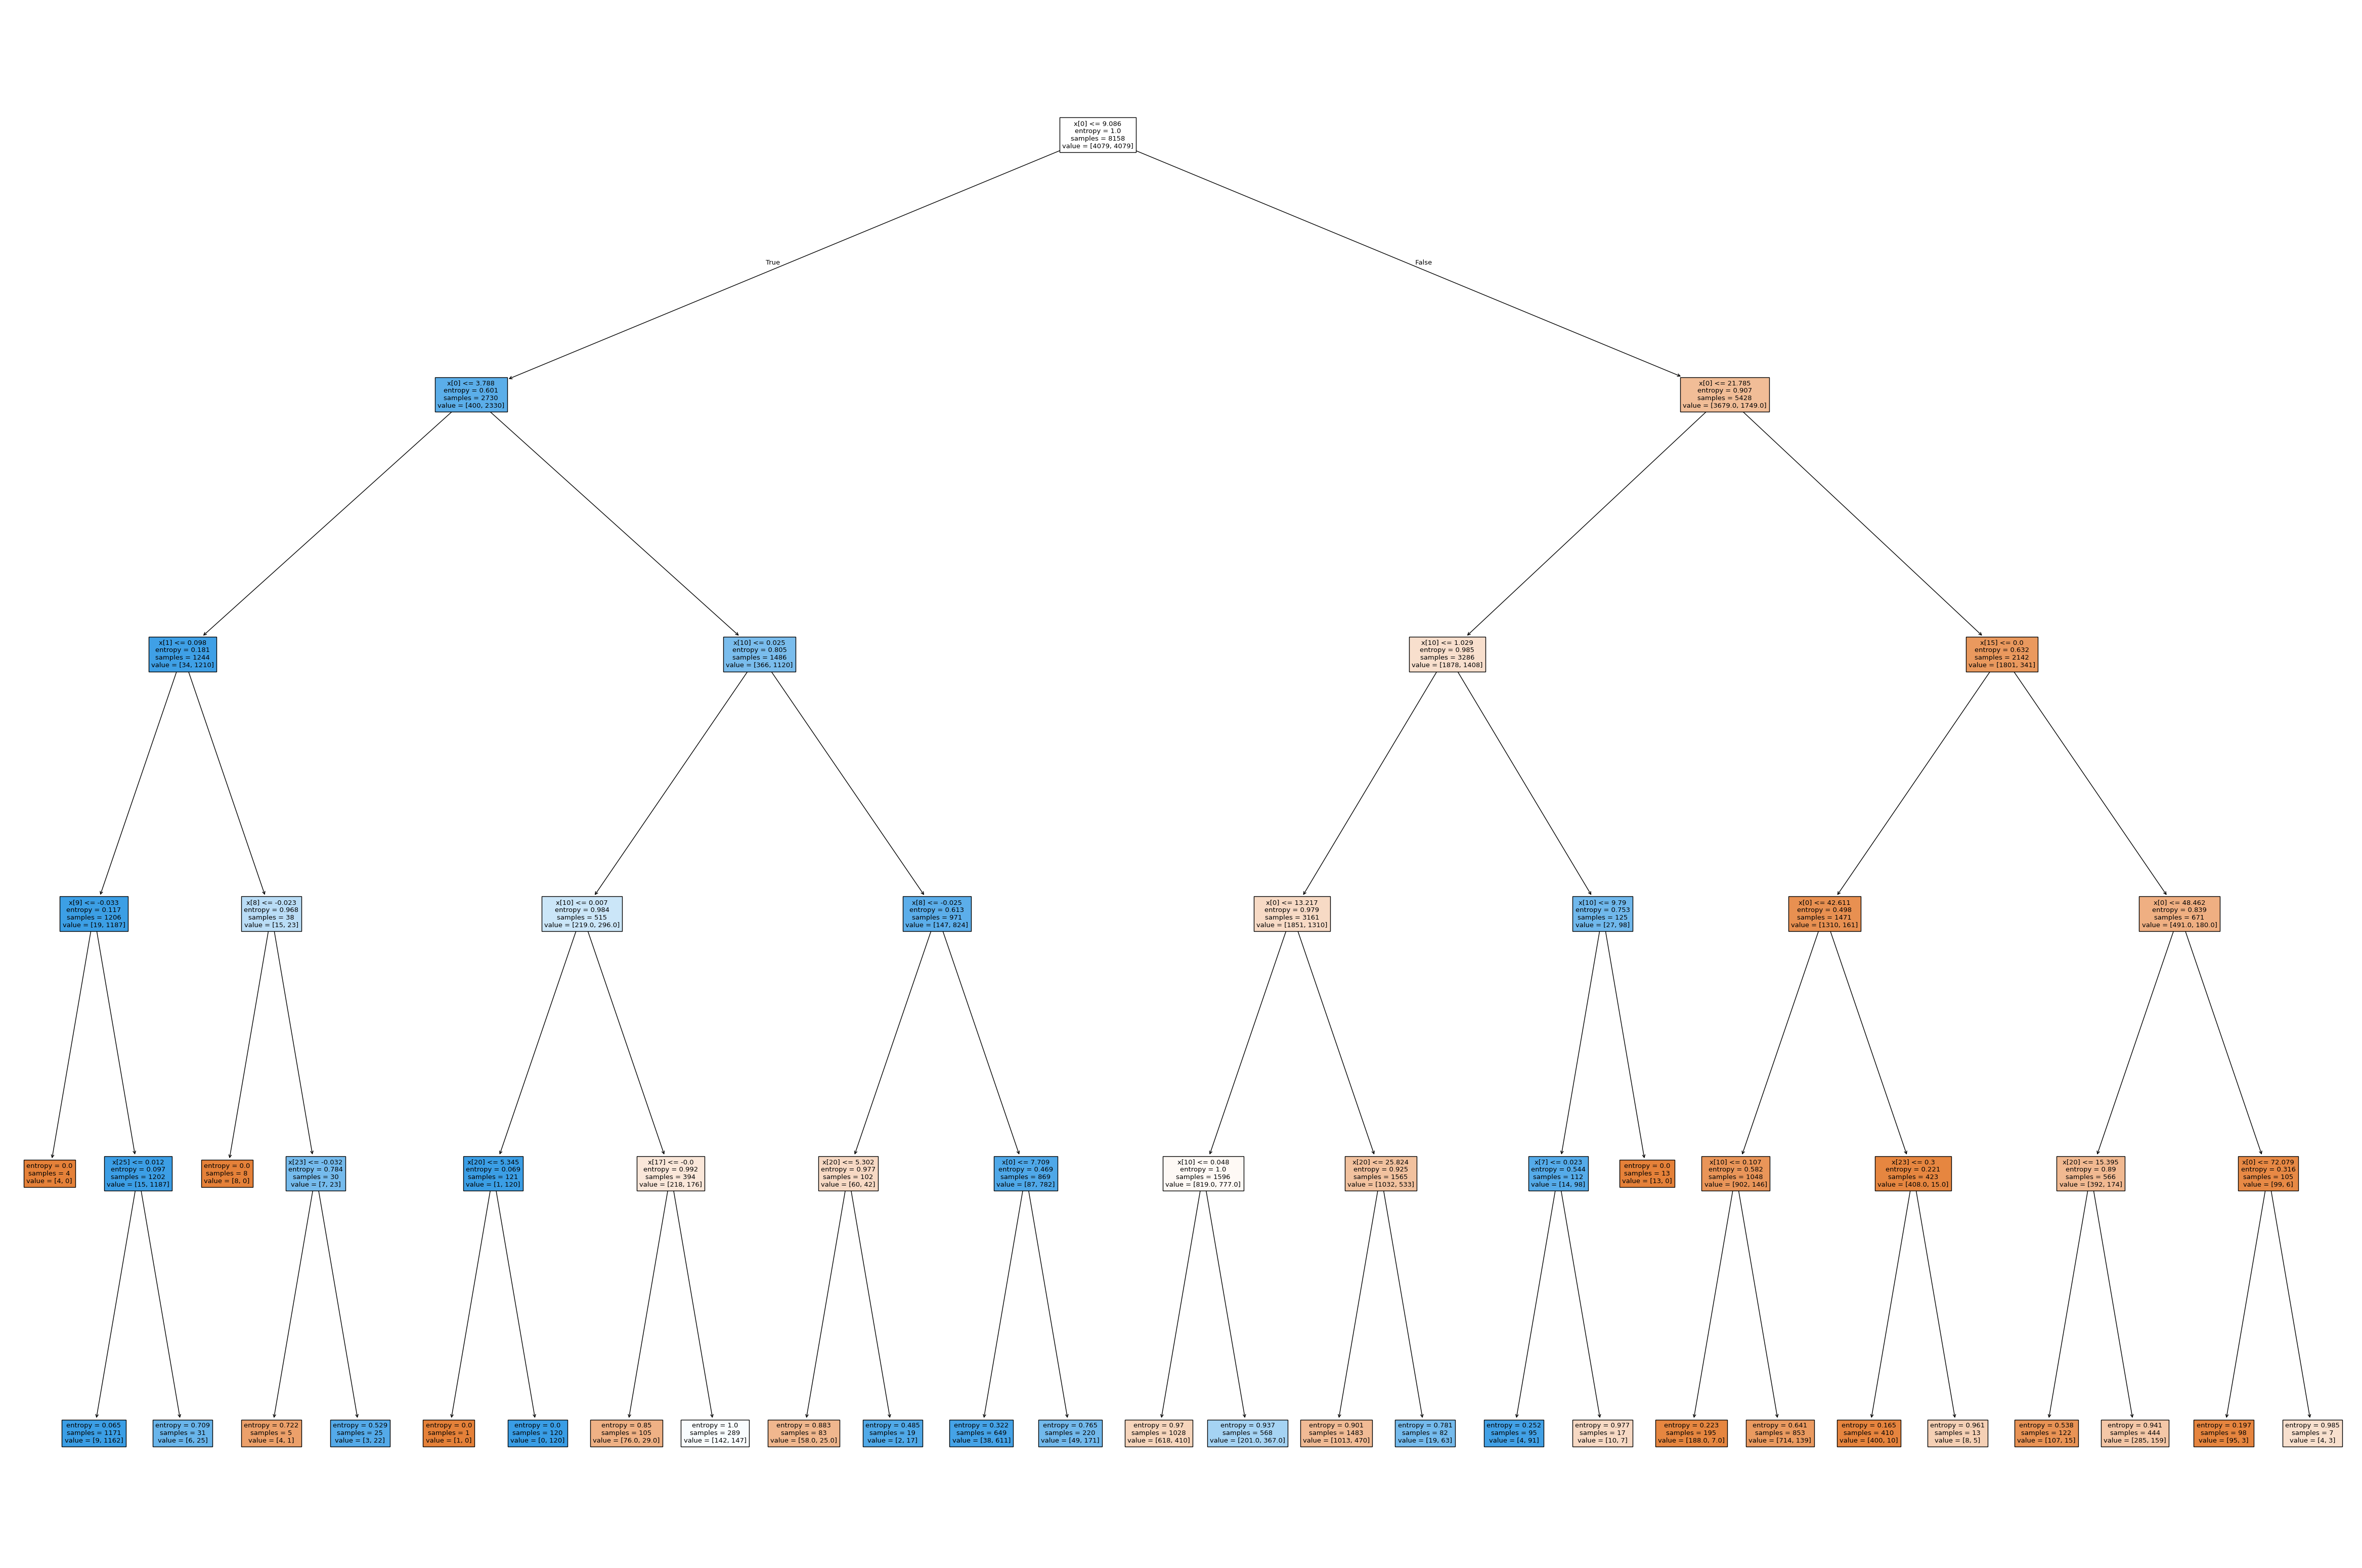

In [ ]:
plt.figure(figsize=(60,40))
plot_tree(dt_clf, filled=True)
plt.show()

## Hyper-parameter Tuning

In [ ]:
possible_max_depths = [2, 3, 4, 5, 6, 7, 8, 9, 10,15]
possible_measures = ['gini', 'entropy']

tuning_results = {}
for measure in possible_measures:
  for max_depth in possible_max_depths:
    dt_clf = DecisionTreeClassifier(criterion=measure, max_depth=max_depth, random_state=seed)
    dt_clf.fit(df_train[expanded_columns], df_train['class'])
    y_pred = dt_clf.predict(df_test[expanded_columns])
    metrics = evaluate_metrics(df_test['class'], y_pred)
    tuning_results[f'{measure}_{max_depth}'] = {k:v for k,v in metrics.items() if k not in ('confusion_matrix', 'classification_report')}


In [ ]:
tuning_df_original = pd.DataFrame.from_dict(tuning_results, orient='index')
tuning_df = tuning_df_original.copy()
tuning_df[['measure', 'depth']] = tuning_df_original.index.to_series().str.extract(r'(\w+)_(\d+)')
tuning_df['depth'] = tuning_df['depth'].astype(int)  # convert depth to int if needed
tuning_df

,balanced_accuracy,geometric_mean,f1_macro,f1_weighted,accuracy,precision_macro,precision_weighted,recall_macro,recall_weighted,jaccard_macro,jaccard_weighted,tss,hss,measure,depth
gini_2,0.617848,0.571051,0.506789,0.895493,0.843000,0.520347,0.962394,0.617848,0.843000,0.052396,0.823688,0.235695,0.062517,gini,2
gini_3,0.586866,0.522768,0.498636,0.894363,0.841439,0.515100,0.960601,0.586866,0.841439,0.043877,0.822177,0.173733,0.046412,gini,3
gini_4,0.586787,0.522719,0.498552,0.894271,0.841283,0.515073,0.960597,0.586787,0.841283,0.043836,0.822022,0.173573,0.046328,gini,4
gini_5,0.586926,0.522804,0.498700,0.894432,0.841556,0.515120,0.960604,0.586926,0.841556,0.043908,0.822293,0.173853,0.046475,gini,5
gini_6,0.522677,0.217078,0.535946,0.967561,0.976532,0.674953,0.964496,0.522677,0.976532,0.043720,0.955307,0.045354,0.079059,gini,6
gini_7,0.571925,0.498169,0.494432,0.893468,0.840093,0.512501,0.959737,0.571925,0.840093,0.039714,0.820862,0.143850,0.038425,gini,7
gini_8,0.574879,0.503256,0.495173,0.893511,0.840132,0.512998,0.959908,0.574879,0.840132,0.040510,0.820897,0.149758,0.039949,gini,8
gini_9,0.573282,0.500409,0.494842,0.893592,0.840288,0.512743,0.959816,0.573282,0.840288,0.040098,0.821054,0.146564,0.039167,gini,9
gini_10,0.569609,0.494873,0.493376,0.892717,0.838844,0.512027,0.959605,0.569609,0.838844,0.038972,0.819630,0.139218,0.036956,gini,10
gini_15,0.570577,0.498342,0.492439,0.890940,0.835821,0.511984,0.959665,0.570577,0.835821,0.038940,0.816636,0.141155,0.036786,gini,15


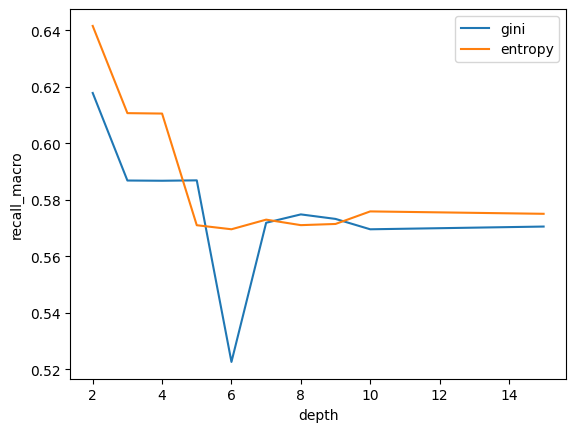

In [ ]:
sns.lineplot(tuning_df[tuning_df['measure'] == 'gini'], x='depth', y='recall_macro', label='gini')
sns.lineplot(tuning_df[tuning_df['measure'] == 'entropy'], x='depth', y='recall_macro', label='entropy')
plt.legend()
plt.show()

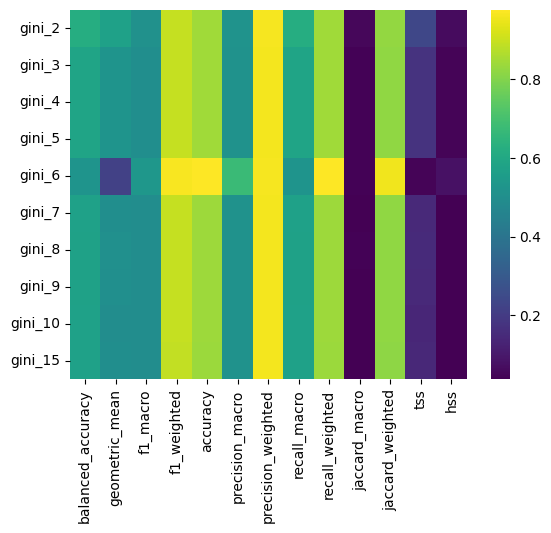

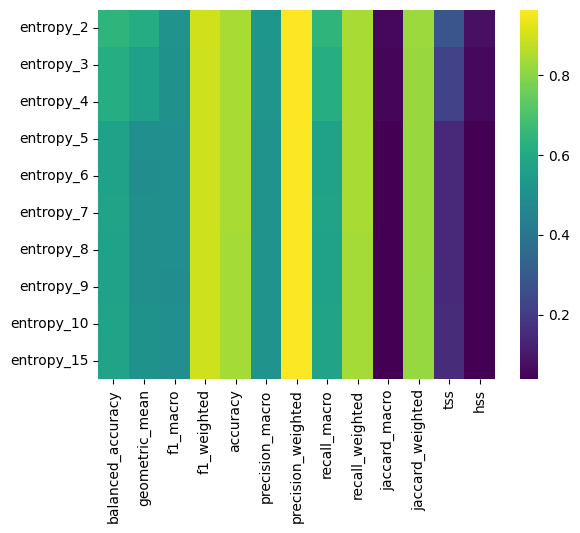

In [ ]:
sns.heatmap(tuning_df_original[tuning_df['measure'] == 'gini'], cmap='viridis')
plt.show()
sns.heatmap(tuning_df_original[tuning_df['measure'] == 'entropy'], cmap='viridis')
plt.show()

# Random Forest Classifier

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=5, random_state=seed)
rf_clf.fit(df_train[expanded_columns], df_train['class'])

RandomForestClassifier(criterion='entropy', max_depth=5, random_state=42)

In [ ]:
important_columns = [expanded_columns[i] for i in reversed(rf_clf.feature_importances_.argsort())]
print(important_columns)

['TOTUSJH_real_0', 'TOTUSJZ_real_0', 'TOTPOT_real_0', 'TOTUSJH_real_6', 'TOTUSJH_real_8', 'TOTPOT_real_6', 'TOTUSJH_real_7', 'TOTPOT_real_7', 'TOTUSJH_real_5', 'TOTUSJH_real_9', 'TOTUSJZ_real_7', 'TOTUSJH_real_1', 'TOTPOT_real_9', 'TOTPOT_real_8', 'TOTUSJZ_real_5', 'TOTUSJH_real_3', 'TOTUSJH_real_2', 'TOTUSJZ_real_9', 'TOTUSJH_real_4', 'TOTUSJZ_real_6', 'TOTUSJZ_real_3', 'TOTPOT_real_5', 'TOTUSJZ_real_2', 'TOTPOT_real_3', 'TOTPOT_real_2', 'TOTUSJZ_real_8', 'TOTPOT_real_1', 'TOTUSJZ_real_4', 'TOTPOT_real_4', 'TOTUSJZ_real_1']


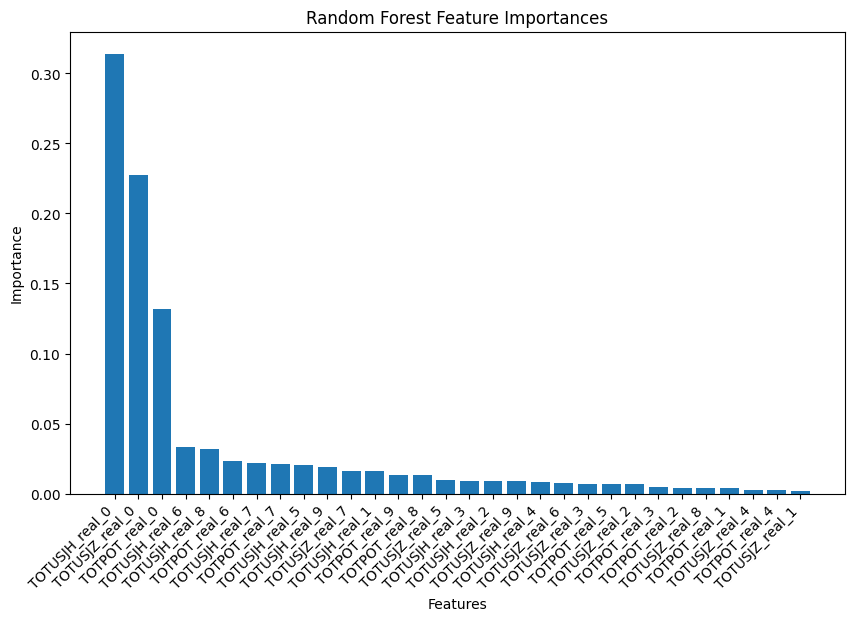

In [ ]:
rf_clf_feature_importances = rf_clf.feature_importances_
sorted_indices = np.argsort(rf_clf_feature_importances)[::-1]
sorted_feature_names = [expanded_columns[i] for i in sorted_indices]
sorted_importances = rf_clf_feature_importances[sorted_indices]
plt ==plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=45, ha='right')
plt.title('Random Forest Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
y_pred = rf_clf.predict(df_test[expanded_columns])
metrics = evaluate_metrics(df_test['class'], y_pred)
metrics_dict['random_forest'] = metrics
print_metrics(metrics, title ='Random Forest Classifier')

Random Forest Classifier Results
balanced_accuracy   : 0.61512
geometric_mean      : 0.56709
f1_macro            : 0.50595
f1_weighted         : 0.89523
accuracy            : 0.84259
precision_macro     : 0.51986
precision_weighted  : 0.96224
recall_macro        : 0.61512
recall_weighted     : 0.84259
jaccard_macro       : 0.05160
jaccard_weighted    : 0.82328
confusion_matrix    
[[  439   726]
 [ 7343 42753]] 

tss                 : 0.23025
hss                 : 0.06101
classification_report
              precision    recall  f1-score   support

          FL       0.06      0.38      0.10      1165
          NF       0.98      0.85      0.91     50096

    accuracy                           0.84     51261
   macro avg       0.52      0.62      0.51     51261
weighted avg       0.96      0.84      0.90     51261
 



In [ ]:
with open('/content/drive/MyDrive/ADM/results/part_123/rf_clf.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

# XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_train['class_encoded'] = label_encoder.fit_transform(df_train['class'])
df_test['class_encoded'] = label_encoder.transform(df_test['class'])
# print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define parameter grid
param_grid = {
    'n_estimators': [100],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10,15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Initialize the classifier
xg_clf = XGBClassifier(random_state=seed)

# Grid search with cross-validation
grid_search = GridSearchCV(xg_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(df_train[expanded_columns], df_train['class_encoded'])

# Best hyperparameters
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100, 'subsample': 1.0}


In [ ]:
xg_clf = XGBClassifier(n_estimators = 100, max_depth = 15, random_state=seed,learning_rate= 0.1,subsample= 1.0)
xg_clf.fit(df_train[expanded_columns], df_train['class_encoded'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
important_columns = [expanded_columns[i] for i in reversed(xg_clf.feature_importances_.argsort())]
print(important_columns)

['TOTUSJH_real_0', 'TOTPOT_real_0', 'TOTUSJZ_real_0', 'TOTUSJH_real_8', 'TOTPOT_real_5', 'TOTPOT_real_6', 'TOTPOT_real_7', 'TOTUSJH_real_7', 'TOTUSJH_real_5', 'TOTUSJH_real_6', 'TOTPOT_real_1', 'TOTPOT_real_9', 'TOTUSJZ_real_5', 'TOTUSJH_real_9', 'TOTUSJH_real_1', 'TOTPOT_real_8', 'TOTUSJZ_real_6', 'TOTUSJZ_real_1', 'TOTUSJZ_real_9', 'TOTUSJZ_real_7', 'TOTUSJH_real_3', 'TOTUSJZ_real_8', 'TOTPOT_real_2', 'TOTUSJZ_real_2', 'TOTUSJZ_real_3', 'TOTUSJH_real_4', 'TOTPOT_real_4', 'TOTUSJZ_real_4', 'TOTPOT_real_3', 'TOTUSJH_real_2']


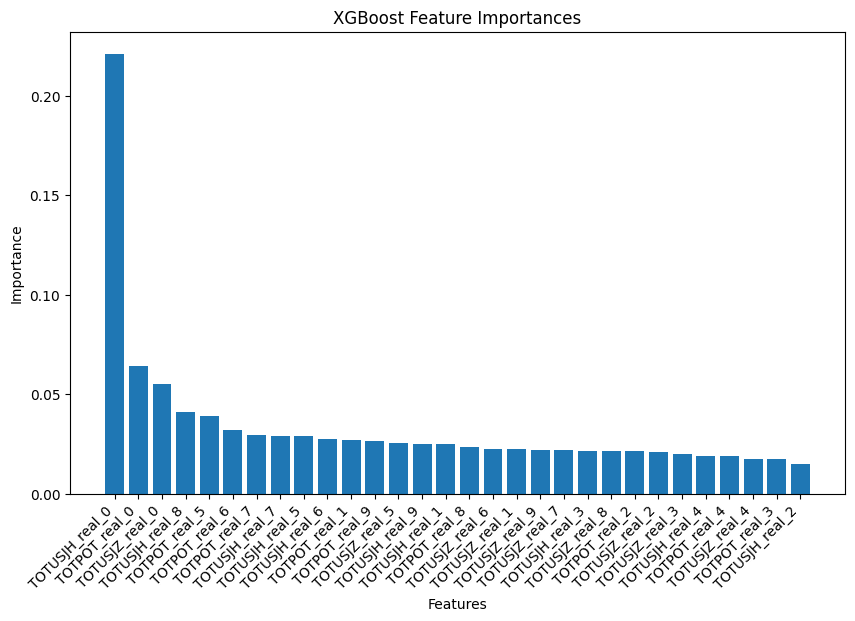

In [ ]:
xg_xlf_feature_importances = xg_clf.feature_importances_
sorted_indices = np.argsort(xg_xlf_feature_importances)[::-1]
sorted_feature_names = [expanded_columns[i] for i in sorted_indices]
sorted_importances = xg_xlf_feature_importances[sorted_indices]
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=45, ha='right')
plt.title('XGBoost Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
y_pred = xg_clf.predict(df_test[expanded_columns])
metrics = evaluate_metrics(df_test['class_encoded'], y_pred)
metrics_dict['XGBoost_Classifier'] = metrics
print_metrics(metrics, title ='XGBoost Classifier')

XGBoost Classifier Results
balanced_accuracy   : 0.56724
geometric_mean      : 0.48904
f1_macro            : 0.49386
f1_weighted         : 0.89432
accuracy            : 0.84159
precision_macro     : 0.51182
precision_weighted  : 0.95946
recall_macro        : 0.56724
recall_weighted     : 0.84159
jaccard_macro       : 0.03860
jaccard_weighted    : 0.82235
confusion_matrix    
[[  326   839]
 [ 7281 42815]] 

tss                 : 0.13449
hss                 : 0.03634
classification_report
              precision    recall  f1-score   support

           0       0.04      0.28      0.07      1165
           1       0.98      0.85      0.91     50096

    accuracy                           0.84     51261
   macro avg       0.51      0.57      0.49     51261
weighted avg       0.96      0.84      0.89     51261
 



In [ ]:
with open('/content/drive/MyDrive/ADM/results/part_123/xgb_clf.pkl', 'wb') as f:
    pickle.dump(xg_clf, f)

# Support Vector Machine Classifier

Min-Max Normalization

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# df_train_class_encoded_column = df_train['class_encoded']
# df_test_class_encoded_column = df_test['class_encoded']

# df_train_scaled = scaler.fit_transform(df_train[expanded_columns])
# df_test_scaled = scaler.transform(df_test[expanded_columns])

# df_train_scaled = pd.DataFrame(df_train_scaled, columns=expanded_columns)
# df_train_scaled['class'] = df_train_class_encoded_column.reset_index(drop=True)

# df_test_scaled = pd.DataFrame(df_test_scaled, columns=expanded_columns)
# df_test_scaled['class'] = df_test_class_encoded_column.reset_index(drop=True)# Ensure proper alignment

In [ ]:
# # print(df_train_scaled.isna().sum())
# # print(df_test_scaled.isna().sum())
# print(df_train_scaled.shape)
# print(df_test_scaled.shape)

# df_train_scaled.dropna(inplace=True)
# df_test_scaled.dropna(inplace=True)
# print(df_train_scaled.shape)
# print(df_test_scaled.shape)

In [ ]:
# from sklearn.svm import  SVC
# X_train = df_train_scaled.drop(columns=['class'])
# y_train = df_train_scaled['class']
# X_test = df_test_scaled.drop(columns=['class'])
# y_test = df_test_scaled['class']
# svm_clf = SVC()
# svm_clf.fit(X_train,y_train)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', 'poly'],
#     'gamma': [0.1, 1, 'scale', 'auto']
# }
# grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=5)
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# y_pred_best = best_model.predict(X_test)
# accuracy_best = accuracy_score(y_test, y_pred_best)
# print(f"Best SVM Accuracy: {accuracy_best:.2f}")
# print(f"Best Hyperparameters: {best_params}")

In [ ]:
# # svm_clf =SVC(**best_params)
# svm_clf = SVC(C=10, gamma =1, kernel= 'rbf')
# svm_clf.fit(X_train,y_train)

In [ ]:
# y_pred = svm_clf.predict(X_test)
# metrics = evaluate_metrics(y_test, y_pred)
# metrics_dict['SVM_Classifier'] = metrics
# print_metrics(metrics, title ='SVM Classifier')
# print(y_pred.shape)

Without normalizing the frequency data

In [ ]:
df_train_cleaned = df_train.dropna()
df_test_cleaned = df_test.dropna()

In [ ]:
from sklearn.svm import  SVC
X_train = df_train_cleaned[expanded_columns]
y_train =  df_train_cleaned['class_encoded']
X_test = df_test_cleaned[expanded_columns]
y_test = df_test_cleaned['class_encoded']


In [ ]:
# from sklearn.model_selection import GridSearchCV
# svm_clf = SVC()
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', 'poly'],
#     'gamma': [0.1, 1, 'scale', 'auto']
# }
# grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=5)
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# y_pred_best = best_model.predict(X_test)
# accuracy_best = accuracy_score(y_test, y_pred_best)
# print(f"Best SVM Accuracy: {accuracy_best:.2f}")
# print(f"Best Hyperparameters: {best_params}")

In [ ]:
svm_clf = SVC(C=10,gamma=1,kernel='linear')
svm_clf.fit(X_train,y_train)

SVC(C=10, gamma=1, kernel='linear')

In [ ]:
y_pred = svm_clf.predict(X_test)
metrics = evaluate_metrics(y_test, y_pred)
metrics_dict['SVM_Classifier'] = metrics
print_metrics(metrics, title ='SVM Classifier')
print(y_pred.shape)

SVM Classifier Results
balanced_accuracy   : 0.55069
geometric_mean      : 0.32119
f1_macro            : 0.56102
f1_weighted         : 0.84023
accuracy            : 0.88293
precision_macro     : 0.88376
precision_weighted  : 0.88313
recall_macro        : 0.55069
recall_weighted     : 0.88293
jaccard_macro       : 0.10200
jaccard_weighted    : 0.78110
confusion_matrix    
[[  92  798]
 [  12 6017]] 

tss                 : 0.10138
hss                 : 0.16257
classification_report
              precision    recall  f1-score   support

           0       0.88      0.10      0.19       890
           1       0.88      1.00      0.94      6029

    accuracy                           0.88      6919
   macro avg       0.88      0.55      0.56      6919
weighted avg       0.88      0.88      0.84      6919
 

(6919,)


In [ ]:
with open('/content/drive/MyDrive/ADM/results/part_123/svm_clf.pkl', 'wb') as f:
    pickle.dump(svm_clf, f)

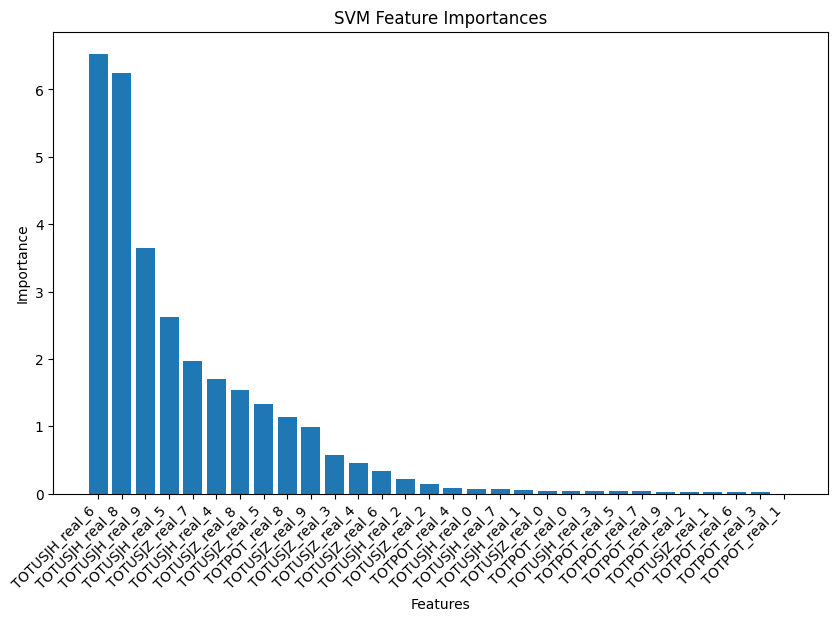

In [ ]:
svm_feature_importances = np.abs(svm_clf.coef_).flatten()
sorted_indices = np.argsort(svm_feature_importances)[::-1]
sorted_feature_names = [expanded_columns[i] for i in sorted_indices]
sorted_importances = svm_feature_importances[sorted_indices]
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=45, ha='right')
plt.title('SVM Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
svm_feature_importances

array([6.60070297e-02, 5.50370701e-02, 2.19085200e-01, 3.65315633e-02,
       1.70571739e+00, 2.62453473e+00, 6.53295398e+00, 6.39988990e-02,
       6.24891475e+00, 3.64334299e+00, 4.13172267e-02, 1.15060233e-03,
       2.70204834e-02, 2.04748105e-02, 8.60154776e-02, 3.60764155e-02,
       2.25640471e-02, 3.60450676e-02, 1.13117956e+00, 2.79994138e-02,
       4.35133411e-02, 2.27218090e-02, 1.47187529e-01, 5.69830996e-01,
       4.57410111e-01, 1.33303566e+00, 3.39371936e-01, 1.96868280e+00,
       1.53602271e+00, 9.95694225e-01])

# Deep learning model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(ResidualBlock, self).__init__()

        self.linear1 = nn.Linear(input_dims, output_dims)
        nn.init.kaiming_normal_(self.linear1.weight, a=0.01, mode="fan_in", nonlinearity="leaky_relu")
        self.bn1 = nn.BatchNorm1d(output_dims)
        self.leaky_relu = nn.LeakyReLU(0.01)

        self.linear2 = nn.Linear(output_dims, output_dims)
        nn.init.kaiming_normal_(self.linear2.weight, a=0.01, mode="fan_in", nonlinearity="leaky_relu")
        self.bn2 = nn.BatchNorm1d(output_dims)

        if input_dims != output_dims:
            self.residual = nn.Linear(input_dims, output_dims)
        else:
            self.residual = nn.Identity()

    def forward(self, x):
        residual = self.residual(x)

        out = self.linear1(x)
        out = self.bn1(out)
        out = self.leaky_relu(out)

        out = self.linear2(out)
        out = self.bn2(out)

        out += residual
        out = self.leaky_relu(out)
        return out

In [ ]:
class ResNetRegressor(nn.Module):
    def __init__(self, input_dim=100, output_dim=8, hidden_dims=[100,100,50,50]):
        super(ResNetRegressor, self).__init__()

        input_layer = nn.Linear(input_dim, hidden_dims[0])
        nn.init.kaiming_normal_(input_layer.weight, a=0.01, mode="fan_in", nonlinearity="leaky_relu")
        bn_input = nn.BatchNorm1d(hidden_dims[0])
        leaky_relu = nn.LeakyReLU()

        self.model_layers = [input_layer, bn_input, leaky_relu]

        for i in range(len(hidden_dims) - 1):
            res_block = ResidualBlock(hidden_dims[i], hidden_dims[i + 1])
            self.model_layers.append(res_block)

        output_layer = nn.Linear(hidden_dims[-1], output_dim)
        self.model_layers.append(output_layer)

        self.architecture = nn.Sequential(*self.model_layers)

    def forward(self, x):
        x = self.architecture(x)
        x = F.sigmoid(x)
        return x

# Visualizing Evaluation Metrics

In [ ]:
refined_dict = { k:{k2:v2 for k2,v2 in v.items() if k2 not in ('confusion_matrix', 'classification_report')} for k,v in metrics_dict.items()}
results_df = pd.DataFrame.from_dict(refined_dict, orient='index')
results_df

,balanced_accuracy,geometric_mean,f1_macro,f1_weighted,accuracy,precision_macro,precision_weighted,recall_macro,recall_weighted,jaccard_macro,jaccard_weighted,tss,hss
decision_tree,0.571046,0.495707,0.494827,0.894379,0.841653,0.512466,0.959685,0.571046,0.841653,0.039636,0.822408,0.142093,0.038333
random_forest,0.615123,0.567089,0.505952,0.895233,0.842590,0.519857,0.962237,0.615123,0.842590,0.051598,0.823284,0.230245,0.061010
XGBoost_Classifier,0.567244,0.489038,0.493857,0.894318,0.841595,0.511818,0.959465,0.567244,0.841595,0.038598,0.822355,0.134487,0.036343
SVM_Classifier,0.550690,0.321193,0.561023,0.840227,0.882931,0.883760,0.883125,0.550690,0.882931,0.101996,0.781104,0.101380,0.162570


In [ ]:
refined_dict = { k:{k2:v2 for k2,v2 in v.items() if k2 not in ('confusion_matrix', 'classification_report')} for k,v in metrics_dict.items()}
results_df = pd.DataFrame.from_dict(refined_dict, orient='index')
results_df

,balanced_accuracy,geometric_mean,f1_macro,f1_weighted,accuracy,precision_macro,precision_weighted,recall_macro,recall_weighted,jaccard_macro,jaccard_weighted,tss,hss
decision_tree,0.571046,0.495707,0.494827,0.894379,0.841653,0.512466,0.959685,0.571046,0.841653,0.039636,0.822408,0.142093,0.038333
random_forest,0.615123,0.567089,0.505952,0.895233,0.842590,0.519857,0.962237,0.615123,0.842590,0.051598,0.823284,0.230245,0.061010
XGBoost_Classifier,0.567244,0.489038,0.493857,0.894318,0.841595,0.511818,0.959465,0.567244,0.841595,0.038598,0.822355,0.134487,0.036343
SVM_Classifier,0.550690,0.321193,0.561023,0.840227,0.882931,0.883760,0.883125,0.550690,0.882931,0.101996,0.781104,0.101380,0.162570


In [ ]:
df_reset = results_df.reset_index().rename(columns={'index': 'Model'})
df_reset.to_csv('/content/drive/MyDrive/ADM/results/part_123/model_eval.csv', index=False)

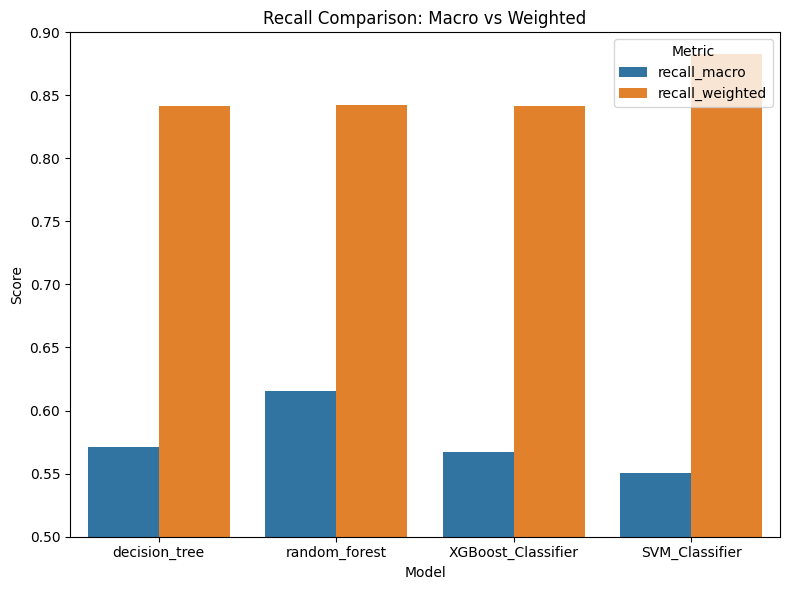

In [ ]:
df_melted = df_reset.melt(id_vars='Model', value_vars=['recall_macro', 'recall_weighted'], var_name='Metric', value_name='Score')
plt.figure(figsize=(8, 6))
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric')
plt.title('Recall Comparison: Macro vs Weighted')
plt.ylabel('Score')
plt.ylim(0.5, 0.9)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

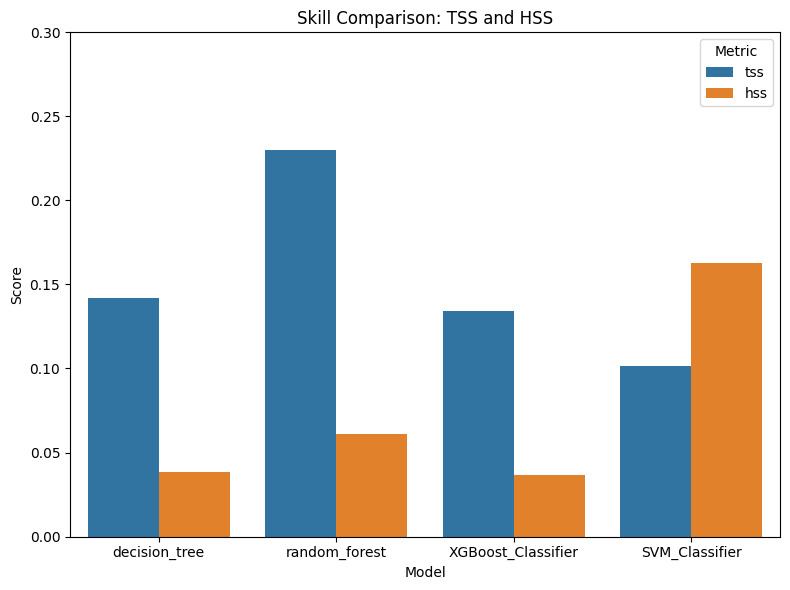

In [ ]:
df_melted = df_reset.melt(id_vars='Model', value_vars=['tss', 'hss'], var_name='Metric', value_name='Score')
plt.figure(figsize=(8, 6))
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric')
plt.title('Skill Comparison: TSS and HSS')
plt.ylabel('Score')
plt.ylim(0, .3)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

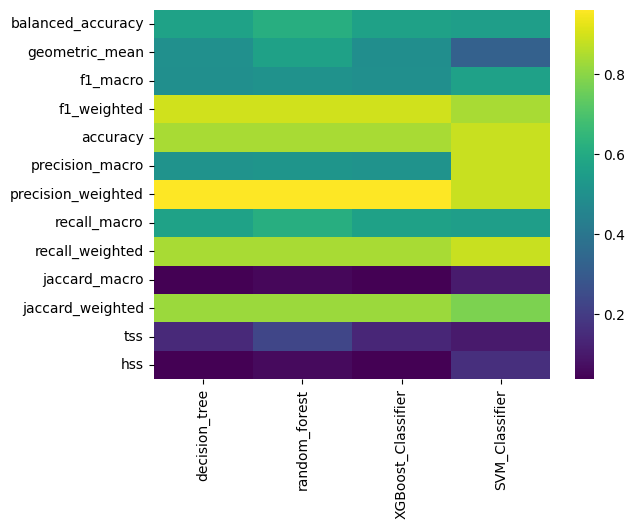

In [ ]:
sns.heatmap(results_df.T, cmap='viridis')
plt.show()

In [ ]:
dd = pd.read_csv('/content/drive/MyDrive/ADM/results/part_123/model_eval.csv', index_col='Model')
dd

,balanced_accuracy,geometric_mean,f1_macro,f1_weighted,accuracy,precision_macro,precision_weighted,recall_macro,recall_weighted,jaccard_macro,jaccard_weighted,tss,hss
Model,,,,,,,,,,,,,
decision_tree,0.571046,0.495707,0.494827,0.894379,0.841653,0.512466,0.959685,0.571046,0.841653,0.039636,0.822408,0.142093,0.038333
random_forest,0.615123,0.567089,0.505952,0.895233,0.842590,0.519857,0.962237,0.615123,0.842590,0.051598,0.823284,0.230245,0.061010
XGBoost_Classifier,0.567244,0.489038,0.493857,0.894318,0.841595,0.511818,0.959465,0.567244,0.841595,0.038598,0.822355,0.134487,0.036343
SVM_Classifier,0.550690,0.321193,0.561023,0.840227,0.882931,0.883760,0.883125,0.550690,0.882931,0.101996,0.781104,0.101380,0.162570
